In [1]:
import random

import keras_cv
import tensorflow as tf

# from keras_cv.backend import keras
from keras_cv import bounding_box, visualization
from pycocotools.coco import COCO
from tensorflow import keras

2024-04-14 19:12:00.381468: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 19:12:00.795740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 19:12:01.922976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm 

In [2]:
# gpus = tf.config.list_physical_devices("GPU")
# tf.config.set_logical_device_configuration(
#     gpus[0],
#     [tf.config.LogicalDeviceConfiguration(memory_limit=8000)],  # Set limit in MB
# )
# logical_gpus = tf.config.list_logical_devices("GPU")
# print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

In [3]:
train_anno = "annotations/dhd_pedestrian_traffic_train.json"
test_anno = "annotations/dhd_pedestrian_traffic_val.json"

train_image_dir = "images/train/"
test_image_dir = "images/val/"

coco_train = COCO(train_anno)
coco_test = COCO(test_anno)

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [4]:
def get_coco_and_dir(img_type):
    """
    Return the corresponding coco, and image dir based on image type (train, test)
    """
    if img_type in ("train", "valid"):
        return coco_train, train_image_dir
    elif img_type == "test":
        return coco_test, test_image_dir
    else:
        raise ValueError("Unknown image type")

In [5]:
def get_bbox(img_type, img_id):
    coco, _ = get_coco_and_dir(img_type)
    annIds = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(annIds)

    categories = []
    bbox = []

    for annotation in anns:
        categories.append(annotation["category_id"])
        bbox.append(annotation["bbox"])

    return categories, bbox

In [6]:
def parse_annotation(img_type, img_id):
    coco, img_dir = get_coco_and_dir(img_type)
    image_path = img_dir + coco.loadImgs(img_id)[0]["file_name"]
    categories, bbox = get_bbox(img_type, img_id)
    return image_path, bbox, categories

In [7]:
train_rate = 0.8

train_valid_imgIds = coco_train.getImgIds()
random.shuffle(train_valid_imgIds)

img_id_list = {}

img_id_list["train"] = train_valid_imgIds[: int(train_rate * len(train_valid_imgIds))]
img_id_list["valid"] = train_valid_imgIds[int(train_rate * len(train_valid_imgIds)) :]
img_id_list["test"] = coco_test.getImgIds()

print("Number of pictures in the train data     :", len(img_id_list["train"]))
print("Number of pictures in the validation data:", len(img_id_list["valid"]))
print("Number of pictures in the test data      :", len(img_id_list["test"]))

Number of pictures in the train data     : 11086
Number of pictures in the validation data: 2772
Number of pictures in the test data      : 2136


In [8]:
def create_raw_dataset(img_type):
    paths = []
    bounding_boxes = []
    categories = []

    for img_id in img_id_list[img_type][:500]:
        path, bbox, category = parse_annotation(img_type, img_id)
        paths.append(path)
        bounding_boxes.append(bbox)
        categories.append(category)

    paths = tf.ragged.constant(paths)
    categories = tf.ragged.constant(categories)
    bounding_boxes = tf.ragged.constant(bounding_boxes)

    return tf.data.Dataset.from_tensor_slices((paths, categories, bounding_boxes))


train_data = create_raw_dataset("train")
valid_data = create_raw_dataset("valid")
test_data = create_raw_dataset("test")

2024-04-14 19:12:04.271524: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (100)


In [9]:
def load_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(img_path, categories, bbox):
    # Read Image
    img = load_image(img_path)
    bounding_boxes = {
        "classes": tf.cast(categories, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(img, tf.float32), "bounding_boxes": bounding_boxes}

In [10]:
augmenter = keras_cv.layers.Augmenter(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        # keras_cv.layers.RandomShear(
        #     x_factor=0.2, y_factor=0.2, bounding_box_format="xywh"
        # ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.8, 1.25), bounding_box_format="xywh"
        ),
    ]
)

In [11]:
BATCH_SIZE = 4

In [12]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xywh",
)

valid_ds = valid_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.shuffle(BATCH_SIZE * 4)
valid_ds = valid_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
valid_ds = valid_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

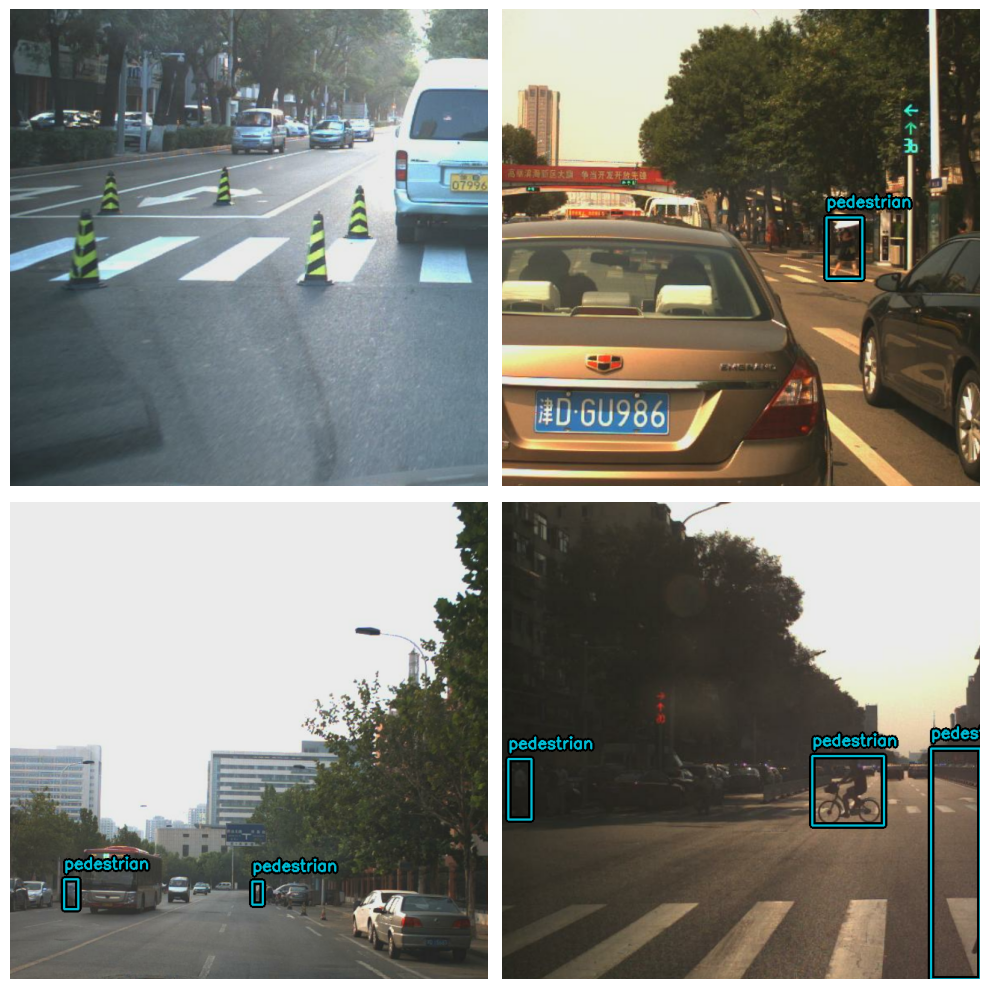

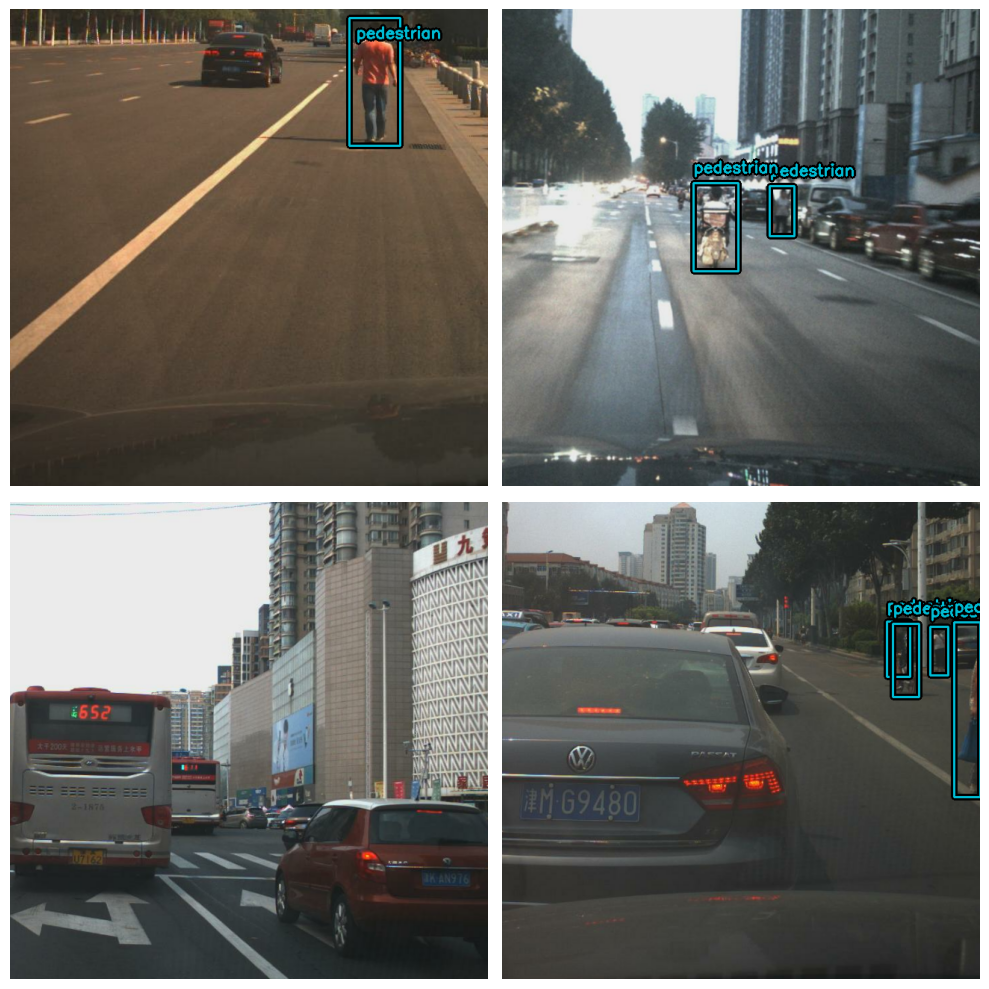

In [14]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping={1: "pedestrian"},
    )


visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    valid_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [15]:
def dict_to_tuple(inputs):
    # return inputs["images"], inputs["bounding_boxes"]
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_dataset = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_ds.prefetch(tf.data.AUTOTUNE)

valid_dataset = valid_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_ds.prefetch(tf.data.AUTOTUNE)

## Training

In [16]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

In [17]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=1,
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=1,
)

In [18]:
yolo.compile(
    optimizer="adam", classification_loss="binary_crossentropy", box_loss="ciou"
)

In [19]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [20]:
network_history = yolo.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=3,
    # callbacks=[EvaluateCOCOMetricsCallback(valid_dataset, "model.h5")],
)

Epoch 1/3


2024-04-14 19:12:30.214129: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedSplit/assert_equal_3/Assert/AssertGuard/branch_executed/_727
2024-04-14 19:12:32.485546: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2024-04-14 19:12:35.604792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: indices[31500,0] = 1 is not in [0, 1)
	 [[{{function_node yolov8_label_encoder_1_cond_true_35031}}{{node yolov8_label_encoder_1/cond/GatherV2}}]]


InvalidArgumentError: Graph execution error:

Detected at node yolov8_label_encoder_1/cond/GatherV2 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_840/3759804936.py", line 1, in <module>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 329, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 122, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/keras_cv/src/models/object_detection/yolo_v8/yolo_v8_detector.py", line 526, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/keras_cv/src/models/object_detection/yolo_v8/yolo_v8_detector.py", line 555, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 826, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/keras_cv/src/models/object_detection/yolo_v8/yolo_v8_label_encoder.py", line 248, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 576, in cond

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 530, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 522, in call_fn

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 536, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/core.py", line 209, in cond

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/keras_cv/src/models/object_detection/yolo_v8/yolo_v8_label_encoder.py", line 250, in <lambda>

  File "/root/Code/DeepLearning_AIT/venv/lib/python3.10/site-packages/keras_cv/src/models/object_detection/yolo_v8/yolo_v8_label_encoder.py", line 92, in assign

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 5019, in take_along_axis

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1744, in take_along_axis

indices[31500,0] = 1 is not in [0, 1)
	 [[{{node yolov8_label_encoder_1/cond/GatherV2}}]] [Op:__inference_one_step_on_iterator_49842]